In [20]:
import importlib
import time
import numpy as np
import scipy as sp
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from scipy import ndimage
from scipy import integrate
from scipy import interpolate
import os
import pickle

In [21]:
from multi_loc import covariance, assimilate, utilities

In [22]:
%matplotlib inline
def imshow(X, title=None, vmin=None, vmax=None, cmap=None):
    plt.figure()
    im = plt.imshow(X, vmin=vmin, vmax=vmax, cmap=cmap)
    plt.colorbar(im)
    plt.title(title)

In [43]:
N_Z = 2**10
print(N_Z)
rho0_l = 0.2
rho0_s = 0.002
# rho0 = 0.2
# dx = 0.25
dz = 1/N_Z

z = np.arange(N_Z)

# obs_size = int(dimension/2)
# H = assimilate.random_H(dimension, obs_size)

rho = np.arange(N_Z, dtype=float)
rho = np.minimum(rho, (N_Z - rho) % N_Z)
rho = rho*dz

1024


In [44]:
coarse = 64
N_X = N_Z // coarse
dx = dz * coarse

In [45]:
N_X

16

In [46]:
eig_val_l, eig_vec_l, P_l, sort_index = covariance.generate_circulant(
    N_Z, dz, rho0_l, covariance.fft_sqd_exp_1d,
    return_Corr=True, return_sort_ind=True)
print('long variance: ', eig_val_l.mean())
eig_val_l = eig_val_l / eig_val_l.mean()
sort_index = np.argsort(sort_index)
eig_val_l = eig_val_l[sort_index]
eig_vec_l = eig_vec_l[:, sort_index]
P_l = eig_vec_l @ np.diag(eig_val_l) @ eig_vec_l.conj().T
P_l = P_l.real

eig_val_s, eig_vec_s, P_s, sort_index = covariance.generate_circulant(
    N_Z, dz, rho0_s, covariance.fft_sqd_exp_1d,
    return_Corr=True, return_sort_ind=True)
print('short variance: ', eig_val_s.mean())
eig_val_s = eig_val_s / eig_val_s.mean()
sort_index = np.argsort(sort_index)
eig_val_s = eig_val_s[sort_index]
eig_vec_s = eig_vec_s[:, sort_index]
P_s = eig_vec_s @ np.diag(eig_val_s) @ eig_vec_s.conj().T
P_s = P_s.real
#P_s = P_s/P_s.max()

al = 0.5
eig_val = (1 - al) * eig_val_s + al * eig_val_l
eig_vec = eig_vec_l.copy()

eig_val = eig_val / eig_val.mean()

sort_index = np.argsort(eig_val)[::-1]
eig_val = eig_val[sort_index]
eig_vec = eig_vec[:, sort_index]

P = eig_vec @ np.diag(eig_val) @ eig_vec.conj().T
P = P.real

sort_index = np.argsort(eig_val_l)[::-1]
eig_val_l = eig_val_l[sort_index]
eig_vec_l = eig_vec_l[:, sort_index]

sort_index = np.argsort(eig_val_s)[::-1]
eig_val_s = eig_val_s[sort_index]
eig_vec_s = eig_vec_s[:, sort_index]

long variance:  1.000007453306344
short variance:  0.999999999875627


In [47]:
P_z = P.copy()
P_x = P[::coarse, ::coarse]

every: 2
sum from Z:  339.95045689630547
sum from X:  69.75703319507366
squared sum from Z:  511.99999999999983
squared sum from X:  422.68829590878187
relative error:  0.17443692205316014
every: 4
sum from Z:  198.67845247850232
sum from X:  49.35840906069487
squared sum from Z:  255.9999999999999
squared sum from X:  211.4751035322372
relative error:  0.17392537682719808
every: 6
sum from Z:  135.94987076000643
sum from X:  40.33179124478021
squared sum from Z:  170.99999999999983
squared sum from X:  141.23318330125093
relative error:  0.17407495145467208
every: 8
sum from Z:  103.21177446717942
sum from X:  34.99383754448483
squared sum from Z:  127.99999999999993
squared sum from X:  105.99946292181124
relative error:  0.1718791959233492
every: 16
sum from Z:  53.55919135592193
sum from X:  25.000489207945993
squared sum from Z:  63.999999999999886
squared sum from X:  53.52355377229111
relative error:  0.16369447230794992
every: 32
sum from Z:  27.924641923906055
sum from X:  18.

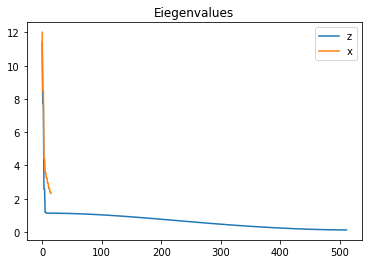

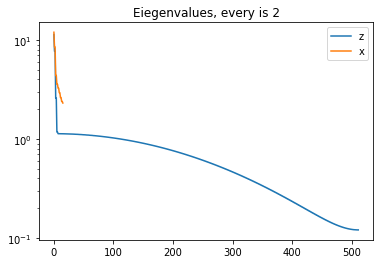

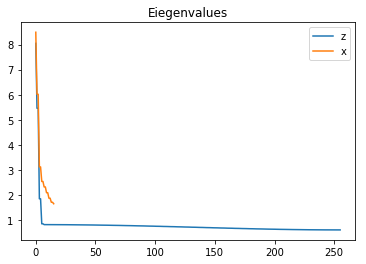

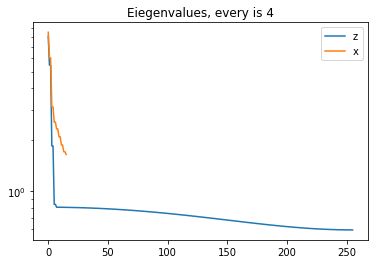

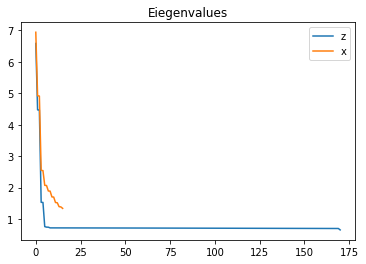

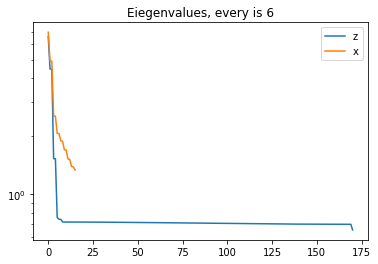

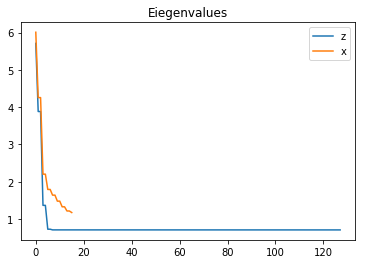

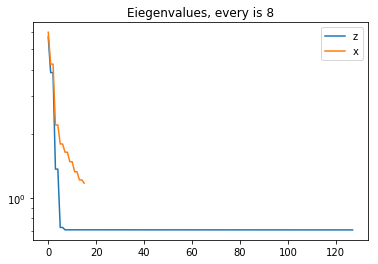

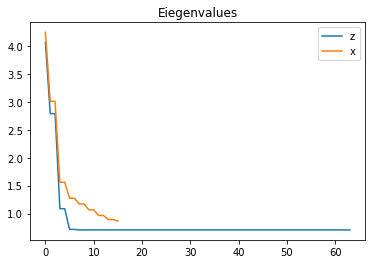

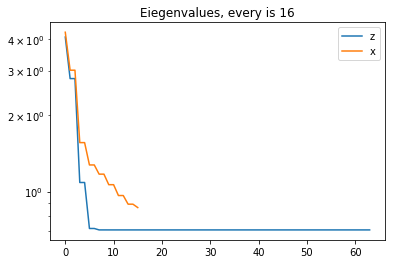

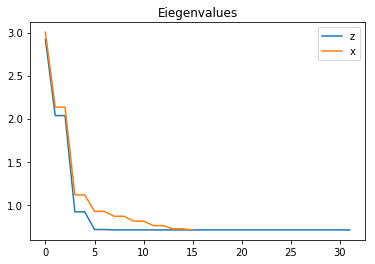

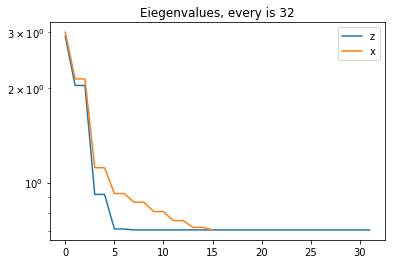

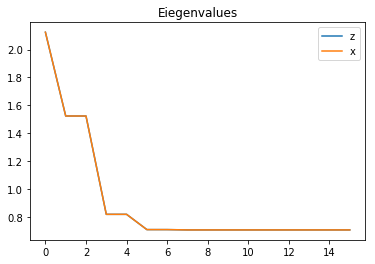

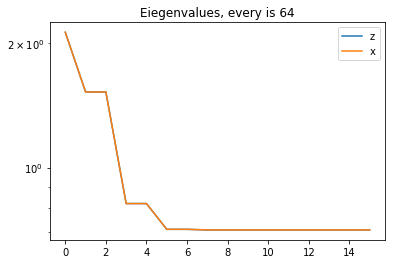

In [48]:
every_array = np.array([2, 4, 6, 8, 16, 32, 64])
relative_ss_error = np.ones_like(every_array) * np.nan
for count, every in enumerate(every_array):
    S_ZX = np.eye(N_Z)[::coarse]
    S_XZ = utilities.lin_interp_matrix(N_Z, coarse)

    H_Z = np.eye(N_Z)[::every]
    H_X = H_Z @ S_XZ

    N_Y = H_Z.shape[0]
    y = H_Z @ z
    R = np.eye(N_Y)

    trans_mats_z = assimilate.transformation_matrices(
        H_Z, P=P_z,
        R=R, return_Ts=True)
    trans_mats_x = assimilate.transformation_matrices(
        H_X, P=P_x,
        R=R, return_Ts=True)

    for key, val in trans_mats_z.items():
        exec(key + '_z=val')
    for key, val in trans_mats_x.items():
        exec(key + '_x=val')
        
    plt.figure()
    plt.plot(np.diag(S_z))
    plt.plot(np.diag(S_x))
    plt.legend(['z', 'x'])
    plt.title('Eiegenvalues')

    plt.figure()
    plt.semilogy(np.diag(S_z))
    plt.semilogy(np.diag(S_x))
    plt.legend(['z', 'x'])
    plt.title(f'Eiegenvalues, every is {every}')

    print(f'every: {every}')
    print('sum from Z: ', np.diag(S_z).sum())
    print('sum from X: ', np.diag(S_x).sum())
    ssZ = (np.diag(S_z)**2).sum()
    ssX = (np.diag(S_x)**2).sum()
    relative_ss_error[count] = (ssZ - ssX)/ssZ
    print('squared sum from Z: ', ssZ)
    print('squared sum from X: ', ssX)
    print('relative error: ', relative_ss_error[count])

Text(0, 0.5, 'Relative error of sigmas')

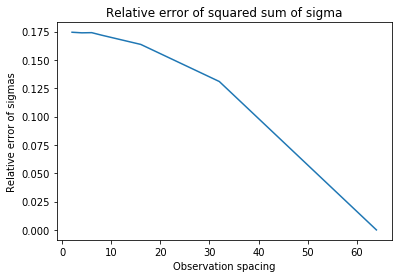

In [49]:
plt.figure()
plt.plot(every_array, relative_ss_error)
plt.title('Relative error of squared sum of sigma')
plt.xlabel('Observation spacing')
plt.ylabel('Relative error of sigmas')